# This is Jeopardy!
    Creating Visualizations with Jeopardy Data


### If you've never seen the show before...

- Three players per game
- Players are choosing and answering questions from a 5x6 (30 question) board
- Each question is worth some amount of money. If they answer correctly that money is added to their total score, if they answer incorrectly that money is subtracted
- The game is divided into three components or "rounds"
    - Round 1: Questions on the board worth \$200-\$1000
    - Round 2: Questions on the board worth \$400-\$2000
    - Final Jeopardy: ("round 3" in the data) All players with a positive score make a wager on a single question.
- Occasionally a chosen question is revealed to be a "Daily Double" at which point the player can make a wager and only that player can answer the question  
- The winner goes on to play the next game against two new players


### About the Data
This data is obtained from J! Archive (j-archive.com) and covers a <a href="https://en.wikipedia.org/wiki/Ken_Jennings#Streak_on_Jeopardy!">very particular set of 75 games</a> between June 2, 2004 and Nov 30, 2004.

Four CSV files:
 - <b>games.csv</b>
     - gameId: Unique ID for that game used by j-archive. You can view full game data at http://www.j-archive.com/showgame.php?game_id=<gameId\>
     - date: Date the game was broadcast
     
 - <b>scores.csv</b>
     - gameId: (see above)
     - playerId: Unique ID for that player used by j-archive. You can view full player data at http://www.j-archive.com/showplayer.php?player_id=<playerId\>
     - breakScore: Score at the first commercial break
     - round1: Score after round 1
     - round2: Score after round 2
     - final: Score after Final Jeopardy question (round 3)
     - coryat: An adjusted score that disregards the effect of wagering (https://j-archive.com/help.php#coryatscore). Used only for analysis purposes, is not an official game score or used in the game in any way
     
- <b>questions.csv</b>
    - gameId: (see above)
    - round: There are two rounds in Jeopardy. Final Jeopardy question is denoted as round '3'
    - pickorder: The order the questions were chosen by players during that round. Final Jeopardy question has value '0'. Note that to get the order questions were picked in throught the <i>game</i> you need to sort by round and then pickorder
    - amount: Amount the question was worth. In the case of Daily Double questions (where a single player wagers an amount of their choosing) this amount is set to what they wagered. In Final Jeopardy the amount is always 0. Players can make different wagers here, so look up their score and do some math if you need this information.

- <b>answers.csv</b>
    - questionId: Unique ID from the questions file
    - playerId: (see above)
    - correct: Boolean whether or not the player answered correctly. 
    
    
### When working through these:

- Use either Matplotlib or Seaborn. Personally, I prefer Seaborn
- If time allows, try to make it pretty
    - Label the axes
    - Add a title
    - Add a legend
    - Make sure the values in the axis are properly formatted
- If you can think of a more interesting visualization than the one I suggested, go for it!


In [319]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set()

## Read and process the data

In [320]:
games = pd.read_csv('../data/games.csv')
games.set_index('id', inplace=True)
games.date = pd.to_datetime(games.date)
games.sort_values(by='date', inplace=True)
games.head()

,date
id,
224,2004-06-02
1517,2004-06-03
1539,2004-06-04
1551,2004-06-07
1552,2004-06-08


In [321]:
scores = pd.read_csv('../data/scores.csv')
scores.head(2)

,gameId,playerId,breakScore,round1,round2,final,coryat
0,920,1,5200,14400,51400,75000,37600
1,920,1874,400,2000,5600,1200,5800


In [322]:
questions = pd.read_csv('../data/questions.csv')
questions.set_index('id', inplace=True)
questions.head(2)

,gameId,round,pickorder,amount
id,,,,
1,920,1,21,200
2,920,1,6,200


In [323]:
answers = pd.read_csv('../data/answers.csv')
answers.head(2)

,questionId,playerId,correct
0,1,1,True
1,1,1874,False


### Make Ranked Data

In [324]:
def first(aList):
    return aList.iloc[0]

def second(aList):
    if len(aList) > 1:
        return aList.iloc[1]

def third(aList):
    if len(aList) > 2:
        return aList.iloc[2]
    
scores.sort_values(by=['gameId', 'final'], ascending=False, inplace=True)
ranked_scores = scores.groupby('gameId').agg({
    'breakScore': [first, second, third],
    'round1': [first, second, third],
    'round2': [first, second, third],
    'final': [first, second, third],
    'coryat': [first, second, third]
})
ranked_scores.head()

breakScore              round1              round2               final  \
            first second third  first second third  first second third  first   
gameId                                                                          
1            4800   1800  1600  13800   3400   800  31600   5000  3200  10001   
2            1800   -800  1000   5800   6000  2200  28400  10800  9600  21800   
3            7200    800  1000  16400   1600  1000  33600   8800  3200  27200   
4            4800    600   600   8100   3000   400  28400   9400  5200  21800   
5            5800   3200     0  13600   6000   600  28600   6000  2600  30000   

                    coryat               
       second third  first second third  
gameId                                   
1        3599  1399  29600   5000  3200  
2       19201     0  25800   8800  7400  
3        8800   200  26400   8800  4200  
4        8399  5200  33400   9400  5200  
5        6000     1  28600   6000  2600

### Add cumulative values

In [325]:
answers_with_scores = answers.merge(questions, how='left', left_on='questionId', right_index=True)
answers_with_scores['score_impact'] = answers_with_scores.apply(lambda r: r['amount'] if r['correct'] else -r['amount'], axis=1)

answers_with_scores['score_cumulative'] = answers_with_scores[
    ['gameId', 'playerId', 'pickorder','round', 'score_impact']].sort_values(by=['round','pickorder']).groupby(
    ['gameId', 'playerId']).cumsum()['score_impact']
answers_with_scores.head()


,questionId,playerId,correct,gameId,round,pickorder,amount,score_impact,score_cumulative
0,1,1,True,920,1,21,200,200,11000
1,1,1874,False,920,1,21,200,-200,600
2,2,1,True,920,1,6,200,200,2800
3,3,1874,True,920,1,28,200,200,1400
4,4,1,True,920,1,1,200,200,200


## 1. Line plot

Create a line plot showing the 1st, 2nd, and 3rd place scores for each game over time (days on the x-axis). Use any score value column you want.


In [326]:
byDate = games.join(ranked_scores['round2'], on='id')  
byDate = byDate.set_index('date') #.drop(columns=['id'])


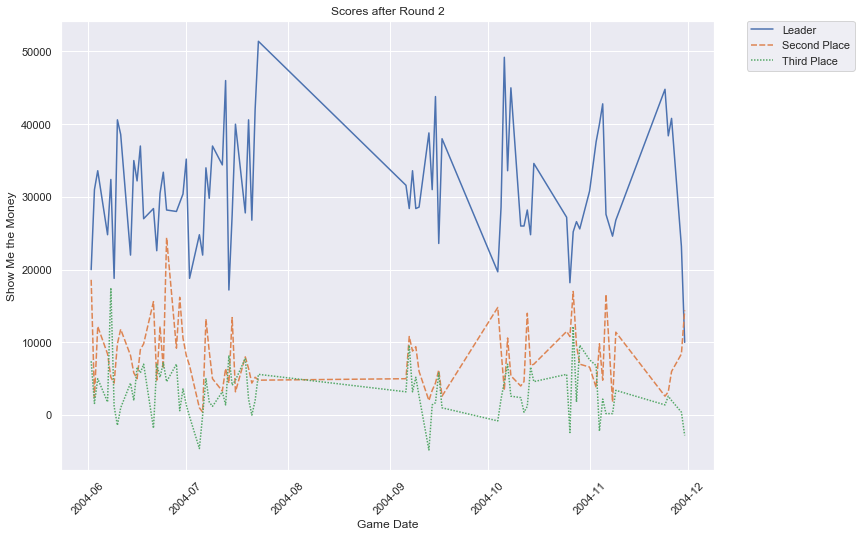

In [327]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data=byDate)
ax.set_ylabel("Show Me the Money")
ax.set_xlabel("Game Date")
plt.legend(['Leader', 'Second Place', 'Third Place'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.title('Scores after Round 2')
plt.show()



## 2. Scatterplot

Create a scatterplot with a dot for each non-Final Jeopardy (round 3) answer across all games and players

<b>x-axis:</b> Question order in game (round, pickorder)<br>
<b>y-axis:</b> Score (after question was answered) of the player answering the question<br>
<b>color:</b> Whether the question was right or wrong.

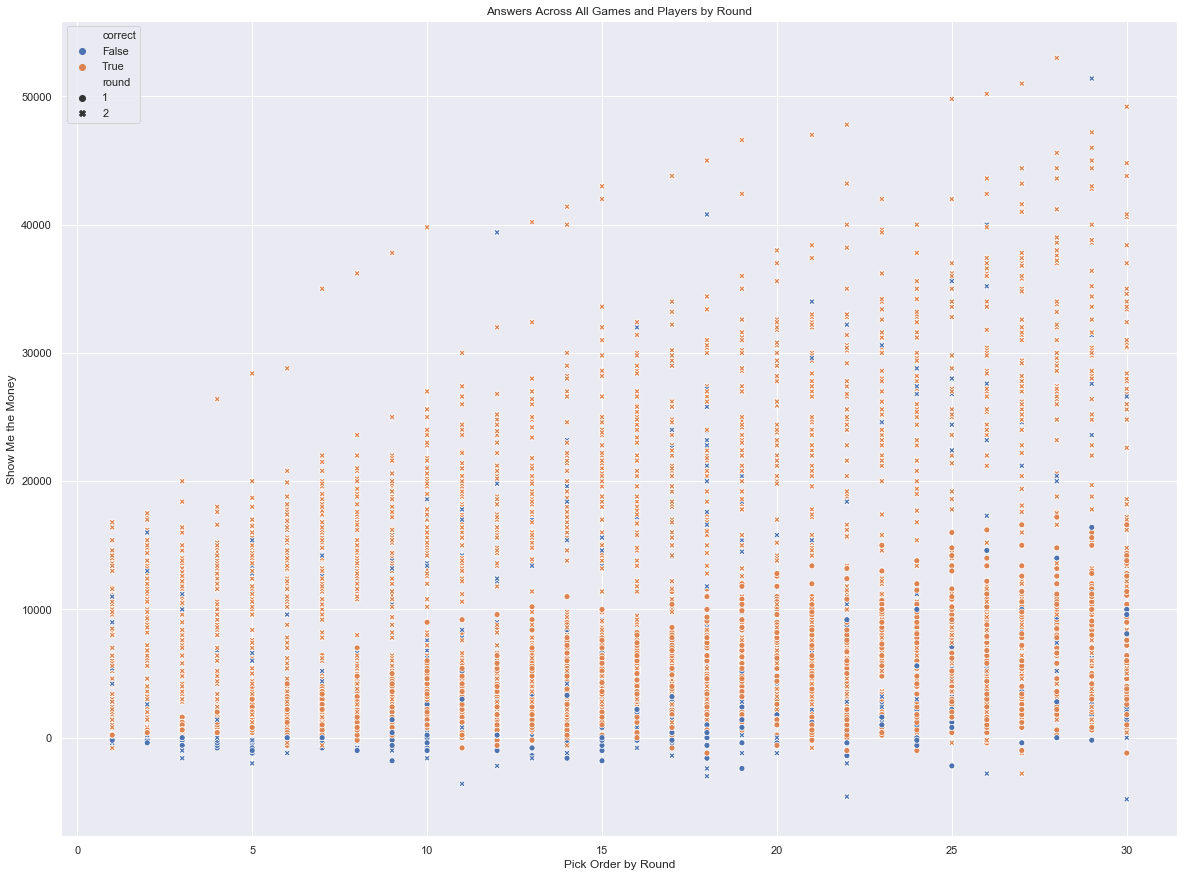

In [333]:
sns.set(rc={'figure.figsize':(20,15)})
roundnot3df = answers_with_scores.loc[answers_with_scores['round'] != 3].copy()
ax = sns.scatterplot('pickorder', 'score_cumulative', data=roundnot3df, hue='correct', style="round");
ax.set_ylabel("Show Me the Money")
ax.set_xlabel("Pick Order by Round")
plt.title('Answers Across All Games and Players by Round')
plt.show()


### 2.2 Splitting up the scatterplot

Design a visualization that differentiates Ken's answers from the other players' in some way. This could be a different shape, different color, two plots, etc.

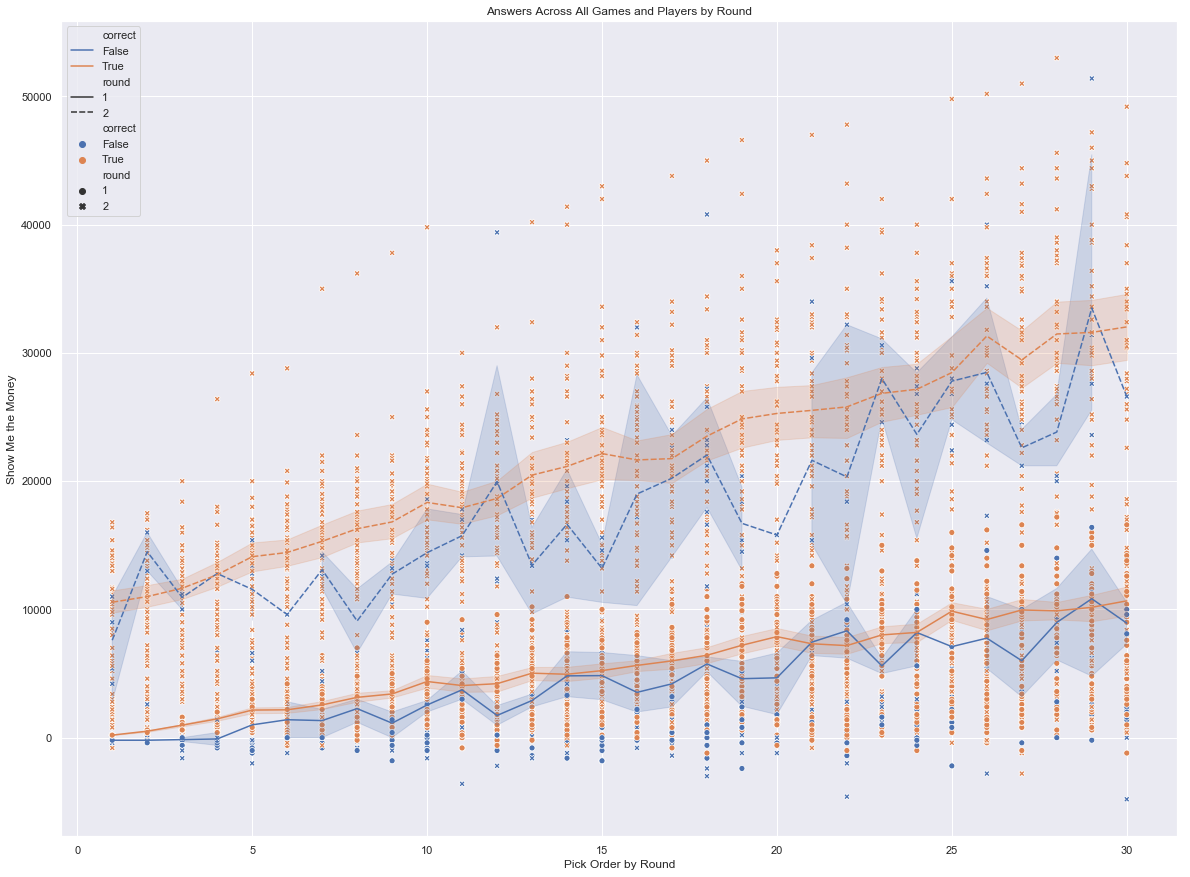

In [347]:
sns.set(rc={'figure.figsize':(20,15)})
roundnot3df = answers_with_scores.loc[answers_with_scores['round'] != 3].copy()
sns.scatterplot('pickorder', 'score_cumulative', data=roundnot3df, hue='correct', style="round");
kendf = roundnot3df.loc[roundnot3df['playerId'] == 1].copy()
ax = sns.lineplot('pickorder', 'score_cumulative', data=kendf, hue='correct', style="round");
ax.set_ylabel("Show Me the Money")
ax.set_xlabel("Pick Order by Round")
plt.title('Answers Across All Games and Players by Round')
plt.show()

### 2.3 Add a line

Add a line plot or line plots showing the average values of your scatterplot across the x-axis. You may want to show lines for only Ken's scores, only third/second place scores, only correct or incorrect answers, etc.


## 3. Bar plot

Create a stacked bar plot showing mean scores of first, second, and third place contestants at various points in the game. The goal is to communicate how champions (and the less champion-ish) tend to build up their score over the course of play. Strong start? Major gains in the second round?

You will find that third place tends to lose at Final Jeopardy more often than they win, leaving you with a negative value for the difference between their round2 and final score. Choose how best to represent this.


## 4. Histogram
Create a plot with four subplots. In each subplot draw two overlapping histograms. One histogram showing the distribution of Ken Jenning's scores and another one showing the distribution of all other player's scores at the following different points in the game:

- End of Round 1
- End of Round 2
- Final score
- Coryat-adjusted score

Note: You should have half the data in the "Ken" histograms as in the "non-Ken" histograms
Also, do not use the "first, second, third" place scores for this -- Ken is not guaranteed to be in first place